## Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# 1.Открываем датасеты и знакомимся с данными

In [1]:
import numpy as np 
import pandas as pd
from scipy import stats as st 
import matplotlib as plt

In [2]:
# открываем таблицы, сразу переводим даты в формат даты 
try:
    dfc = pd.read_csv('D:/backUp/calls.csv', parse_dates=['call_date'])
    dfi = pd.read_csv('D:/backUp/internet.csv',parse_dates=['session_date'])
    dfm = pd.read_csv('D:/backUp/messages.csv',parse_dates=['message_date'])
    dft = pd.read_csv('D:/backUp/tariffs.csv')
    dfu = pd.read_csv('D:/backUp/users.csv',parse_dates=['churn_date','reg_date'])
except:
    dfc = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date'])
    dfi = pd.read_csv('/datasets/internet.csv',parse_dates=['session_date'])
    dfm = pd.read_csv('/datasets/messages.csv',parse_dates=['message_date'])
    dft = pd.read_csv('/datasets/tariffs.csv')
    dfu = pd.read_csv('/datasets/users.csv',parse_dates=['churn_date','reg_date'])

In [3]:
dfc.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [5]:
dfi.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
dfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [7]:
dfm.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [9]:
dft.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [10]:
dfu.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [11]:
dfu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Данные в правильном формате, нету пропусков, кроме "churn_date", но там пропуски ожидаемы. Далее будет уместно проверить на наличие дубликатов.

# 2. Подготавливаем данные

In [12]:
# округляем время звонки до целого в сторону большего, меняем тип на интежер
dfc['duration'] = dfc['duration'].apply(np.ceil).astype(int)

In [13]:
dfc.duplicated().sum()

0

In [14]:
#удаляем столбец дублирующий индексы 
dfi = dfi.drop(labels='Unnamed: 0', axis=1)

In [15]:
# ищем дубликаты
dfi.duplicated().sum()

0

In [16]:
dfm.duplicated().sum()

0

In [17]:
dfu.duplicated().sum()

0

In [18]:
# вычленяем месяц из даты 
dfc['month'] = dfc['call_date'].dt.month

In [19]:
dfi['month'] = dfi['session_date'].dt.month

In [20]:
dfm['month'] = dfm['message_date'].dt.month

In [21]:
dfu['month_start'] = dfu['reg_date'].dt.month

In [22]:
dfu['month_finish'] = dfu['churn_date'].dt.month

In [23]:
# группируем таблицу по юзерам и месяцам, считаем кол-во звонков и общую продолжительность звонков по месяцам
dfc_piv = dfc.groupby(['user_id','month']).agg({'duration':['count','sum']}).reset_index()

In [24]:
dfc_piv.columns = ['user_id','month','calls_count','calls_duration']

In [25]:
dfc_piv.head()

,user_id,month,calls_count,calls_duration
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


In [26]:
dfc_piv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 4 columns):
user_id           3174 non-null int64
month             3174 non-null int64
calls_count       3174 non-null int64
calls_duration    3174 non-null int32
dtypes: int32(1), int64(3)
memory usage: 86.9 KB


In [27]:
# группируем таблицу по юзерам и месяцам, считаем кол-во сообщений по месяцам
dfm_piv = dfm.groupby(['user_id','month']).agg({'id':'count'}).reset_index()

In [28]:
dfm_piv.columns = ['user_id','month','message_count']

In [29]:
dfm_piv.head()

,user_id,month,message_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [30]:
dfm_piv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
user_id          2717 non-null int64
month            2717 non-null int64
message_count    2717 non-null int64
dtypes: int64(3)
memory usage: 63.8 KB


In [31]:
# объединяем 2 таблицы по столбцам user_id и month
df_c_m = dfc_piv.merge(dfm_piv,on=['user_id','month'],how='outer')

In [32]:
df_c_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 0 to 3212
Data columns (total 5 columns):
user_id           3213 non-null int64
month             3213 non-null int64
calls_count       3174 non-null float64
calls_duration    3174 non-null float64
message_count     2717 non-null float64
dtypes: float64(3), int64(2)
memory usage: 150.6 KB


In [33]:
df_c_m.head()

,user_id,month,calls_count,calls_duration,message_count
0,1000,5,22.0,159.0,22.0
1,1000,6,43.0,172.0,60.0
2,1000,7,47.0,340.0,75.0
3,1000,8,52.0,408.0,81.0
4,1000,9,58.0,466.0,57.0


In [34]:
dfi.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


In [35]:
# группируем таблицу по юзерам и месяцам, считаем кол-во мегабайт использованное пользователями по месяцам
dfi = dfi.groupby(['user_id','month']).agg({'mb_used':'sum'}).reset_index()

In [36]:
# объединяем 2 таблицы
df_c_m_i = df_c_m.merge(dfi,on=['user_id','month'],how='outer')

In [37]:
df_c_m_i.head()

,user_id,month,calls_count,calls_duration,message_count,mb_used
0,1000,5,22.0,159.0,22.0,2253.49
1,1000,6,43.0,172.0,60.0,23233.77
2,1000,7,47.0,340.0,75.0,14003.64
3,1000,8,52.0,408.0,81.0,14055.93
4,1000,9,58.0,466.0,57.0,14568.91


In [38]:
# пересчитываем mb в gb
df_c_m_i['gb_used'] = df_c_m_i['mb_used'] / 1024

In [39]:
df_c_m_i.head()

,user_id,month,calls_count,calls_duration,message_count,mb_used,gb_used
0,1000,5,22.0,159.0,22.0,2253.49,2.200674
1,1000,6,43.0,172.0,60.0,23233.77,22.689229
2,1000,7,47.0,340.0,75.0,14003.64,13.675430
3,1000,8,52.0,408.0,81.0,14055.93,13.726494
4,1000,9,58.0,466.0,57.0,14568.91,14.227451


In [40]:
df_c_m_i['gb_used'] = df_c_m_i['gb_used'].fillna(0)

In [41]:
df_c_m_i['gb_used'] = df_c_m_i['gb_used'].apply(np.ceil).astype(int)

In [42]:
#df_c_m_i = df_c_m_i.drop('mb_used',axis=1)

In [43]:
dfu.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month_start,month_finish
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11,NaN
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,NaN
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8,NaN
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,NaN


In [44]:
# объединяем 2 таблицы
df_c_m_i_u = df_c_m_i.merge(dfu,on='user_id',how='outer')

In [45]:
df_c_m_i_u.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 16 columns):
user_id           3216 non-null int64
month             3214 non-null float64
calls_count       3174 non-null float64
calls_duration    3174 non-null float64
message_count     2717 non-null float64
mb_used           3203 non-null float64
gb_used           3214 non-null float64
age               3216 non-null int64
churn_date        189 non-null datetime64[ns]
city              3216 non-null object
first_name        3216 non-null object
last_name         3216 non-null object
reg_date          3216 non-null datetime64[ns]
tariff            3216 non-null object
month_start       3216 non-null int64
month_finish      189 non-null float64
dtypes: datetime64[ns](2), float64(7), int64(3), object(4)
memory usage: 427.1+ KB


In [46]:
# переименовываем столбец
dft = dft.rename(columns={'tariff_name':'tariff'})

In [47]:
dft.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [48]:
# объединяем 2 таблицы 
df_omni = df_c_m_i_u.merge(dft,on='tariff',how='outer')

In [49]:
df_omni.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 23 columns):
user_id                  3216 non-null int64
month                    3214 non-null float64
calls_count              3174 non-null float64
calls_duration           3174 non-null float64
message_count            2717 non-null float64
mb_used                  3203 non-null float64
gb_used                  3214 non-null float64
age                      3216 non-null int64
churn_date               189 non-null datetime64[ns]
city                     3216 non-null object
first_name               3216 non-null object
last_name                3216 non-null object
reg_date                 3216 non-null datetime64[ns]
tariff                   3216 non-null object
month_start              3216 non-null int64
month_finish             189 non-null float64
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_

In [50]:
df_omni = df_omni.query('month in [1,2,3,4,5,6,7,8,9,10,11,12]')

In [51]:
for x in df_omni.columns:
    df_omni[x] = df_omni[x].fillna(0)

In [52]:
df_omni.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3214
Data columns (total 23 columns):
user_id                  3214 non-null int64
month                    3214 non-null float64
calls_count              3214 non-null float64
calls_duration           3214 non-null float64
message_count            3214 non-null float64
mb_used                  3214 non-null float64
gb_used                  3214 non-null float64
age                      3214 non-null int64
churn_date               3214 non-null object
city                     3214 non-null object
first_name               3214 non-null object
last_name                3214 non-null object
reg_date                 3214 non-null datetime64[ns]
tariff                   3214 non-null object
month_start              3214 non-null int64
month_finish             3214 non-null float64
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthl

In [53]:
df_omni = df_omni[(df_omni['month_finish']==0) | (df_omni['month']<df_omni['month_finish'])]

In [54]:
# заполняем пустые значения нулями 
df_omni['message_count'] = df_omni['message_count'].fillna(0)

In [55]:
df_omni['mb_used'] = df_omni['mb_used'].fillna(0)

In [56]:
# считаем перерасходы по тарифам 
df_omni['minutes_overrun'] = df_omni['calls_duration'] - df_omni['minutes_included']

In [57]:
df_omni['message_overrun'] = df_omni['message_count'] - df_omni['messages_included']

In [58]:
df_omni['mb_overrun'] = df_omni['mb_used'] - df_omni['mb_per_month_included']

In [59]:
df_omni['gb_overrun'] = np.ceil(df_omni['mb_overrun']/1024)

In [60]:
df_omni.head()

,user_id,month,calls_count,calls_duration,message_count,mb_used,gb_used,age,churn_date,city,...,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,message_overrun,mb_overrun,gb_overrun
0,1000,5.0,22.0,159.0,22.0,2253.49,3.0,52,0,Краснодар,...,30720,3000,1950,150,1,1,-2841.0,-978.0,-28466.51,-27.0
1,1000,6.0,43.0,172.0,60.0,23233.77,23.0,52,0,Краснодар,...,30720,3000,1950,150,1,1,-2828.0,-940.0,-7486.23,-7.0
2,1000,7.0,47.0,340.0,75.0,14003.64,14.0,52,0,Краснодар,...,30720,3000,1950,150,1,1,-2660.0,-925.0,-16716.36,-16.0
3,1000,8.0,52.0,408.0,81.0,14055.93,14.0,52,0,Краснодар,...,30720,3000,1950,150,1,1,-2592.0,-919.0,-16664.07,-16.0
4,1000,9.0,58.0,466.0,57.0,14568.91,15.0,52,0,Краснодар,...,30720,3000,1950,150,1,1,-2534.0,-943.0,-16151.09,-15.0


In [61]:
# разделяем таблицу на 2 для разных тарифов
df_omni_smart = df_omni[df_omni['tariff']=='smart']

In [62]:
df_omni_ultra = df_omni[df_omni['tariff']=='ultra']

In [63]:
# функция для расчета дохода с пользователя
def revenue(df):
    value_min = 0
    value_mes = 0
    value_mb = 0 
    if df['minutes_overrun']>0:
        value_min = df['minutes_overrun']*df['rub_per_minute']
    if df['message_overrun']>0: 
        value_mes = df['message_overrun']*df['rub_per_message']
    if df['gb_overrun']>0:
        value_mb = df['gb_overrun']*df['rub_per_gb']
    return value_min + value_mes + value_mb + df['rub_monthly_fee']
    

In [64]:
df_omni.loc[:,'income'] = df_omni.apply(revenue,axis=1)

In [65]:
df_omni.sample(10)

,user_id,month,calls_count,calls_duration,message_count,mb_used,gb_used,age,churn_date,city,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,message_overrun,mb_overrun,gb_overrun,income
1131,1032,1.0,61.0,380.0,38.0,24127.69,24.0,31,0,Ульяновск,...,500,550,200,3,3,-120.0,-12.0,8767.69,9.0,2350.0
3172,1490,10.0,42.0,312.0,45.0,20664.97,21.0,30,0,Москва,...,500,550,200,3,3,-188.0,-5.0,5304.97,6.0,1750.0
2137,1248,11.0,96.0,636.0,0.0,17911.75,18.0,51,0,Москва,...,500,550,200,3,3,136.0,-50.0,2551.75,3.0,1558.0
2871,1425,11.0,86.0,585.0,86.0,16126.96,16.0,51,0,Пермь,...,500,550,200,3,3,85.0,36.0,766.96,1.0,1113.0
3010,1457,5.0,70.0,490.0,28.0,22586.65,23.0,35,0,Саратов,...,500,550,200,3,3,-10.0,-22.0,7226.65,8.0,2150.0
2748,1401,1.0,15.0,153.0,14.0,5144.72,6.0,42,0,Москва,...,500,550,200,3,3,-347.0,-36.0,-10215.28,-9.0,550.0
2625,1372,7.0,58.0,380.0,41.0,13658.02,14.0,71,0,Магнитогорск,...,500,550,200,3,3,-120.0,-9.0,-1701.98,-1.0,550.0
117,1080,11.0,105.0,654.0,64.0,5438.97,6.0,28,0,Москва,...,3000,1950,150,1,1,-2346.0,-936.0,-25281.03,-24.0,1950.0
3150,1483,12.0,96.0,691.0,43.0,20902.50,21.0,28,0,Ульяновск,...,500,550,200,3,3,191.0,-7.0,5542.50,6.0,2323.0
1057,1012,7.0,43.0,223.0,12.0,23090.75,23.0,38,0,Санкт-Петербург,...,500,550,200,3,3,-277.0,-38.0,7730.75,8.0,2150.0


In [66]:
df_omni_ultra.loc[:,'income'] = df_omni_ultra.apply(revenue,axis=1)

C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\anton\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [67]:
df_omni_smart.loc[:,'income'] = df_omni_smart.apply(revenue,axis=1)

In [68]:
df_omni_ultra.head()

,user_id,month,calls_count,calls_duration,message_count,mb_used,gb_used,age,churn_date,city,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,message_overrun,mb_overrun,gb_overrun,income
0,1000,5.0,22.0,159.0,22.0,2253.49,3.0,52,0,Краснодар,...,3000,1950,150,1,1,-2841.0,-978.0,-28466.51,-27.0,1950.0
1,1000,6.0,43.0,172.0,60.0,23233.77,23.0,52,0,Краснодар,...,3000,1950,150,1,1,-2828.0,-940.0,-7486.23,-7.0,1950.0
2,1000,7.0,47.0,340.0,75.0,14003.64,14.0,52,0,Краснодар,...,3000,1950,150,1,1,-2660.0,-925.0,-16716.36,-16.0,1950.0
3,1000,8.0,52.0,408.0,81.0,14055.93,14.0,52,0,Краснодар,...,3000,1950,150,1,1,-2592.0,-919.0,-16664.07,-16.0,1950.0
4,1000,9.0,58.0,466.0,57.0,14568.91,15.0,52,0,Краснодар,...,3000,1950,150,1,1,-2534.0,-943.0,-16151.09,-15.0,1950.0


In [69]:
df_omni_smart.head()

,user_id,month,calls_count,calls_duration,message_count,mb_used,gb_used,age,churn_date,city,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,message_overrun,mb_overrun,gb_overrun,income
986,1001,11.0,59.0,430.0,0.0,18429.34,18.0,41,0,Москва,...,500,550,200,3,3,-70.0,-50.0,3069.34,3.0,1150.0
987,1001,12.0,63.0,414.0,0.0,14036.66,14.0,41,0,Москва,...,500,550,200,3,3,-86.0,-50.0,-1323.34,-1.0,550.0
988,1002,6.0,15.0,117.0,4.0,10856.82,11.0,59,0,Стерлитамак,...,500,550,200,3,3,-383.0,-46.0,-4503.18,-4.0,550.0
989,1002,7.0,26.0,214.0,11.0,17580.10,18.0,59,0,Стерлитамак,...,500,550,200,3,3,-286.0,-39.0,2220.10,3.0,1150.0
990,1002,8.0,42.0,289.0,13.0,20319.26,20.0,59,0,Стерлитамак,...,500,550,200,3,3,-211.0,-37.0,4959.26,5.0,1550.0


Вывод: данные обработаны, все необходимые значения были посчитаны, можно продолжать обработку

<div class="alert alert-info"> <b>Комментарий студента:</b> Вывод: данные обработаны, все необходимые значения были посчитаны, можно продолжать обработку </div>

# 3.Проанализируем данные

In [70]:
df_omni_ultra['calls_duration'].describe()

count     971.000000
mean      531.511843
std       316.864592
min         0.000000
25%       294.000000
50%       521.000000
75%       752.500000
max      1673.000000
Name: calls_duration, dtype: float64

In [71]:
df_omni_ultra['calls_duration'].plot(kind='box')

In [72]:
# считаем среднее, дисперсия и стандартное отклонение для звонков тарифа УЛЬТРА
ultra_mean = df_omni_ultra['calls_duration'].mean()

In [73]:
ultra_variance = df_omni_ultra['calls_duration'].var()

In [74]:
ultra_std = np.sqrt(ultra_variance)

In [75]:
display(f'Среднее={ultra_mean},Дисперсия={ultra_variance},Стандартное отклонение={ultra_std} для тарифа УЛЬТРА')

'Среднее=531.5118434603502,Дисперсия=100403.16970494897,Стандартное отклонение=316.8645920656787 для тарифа УЛЬТРА'

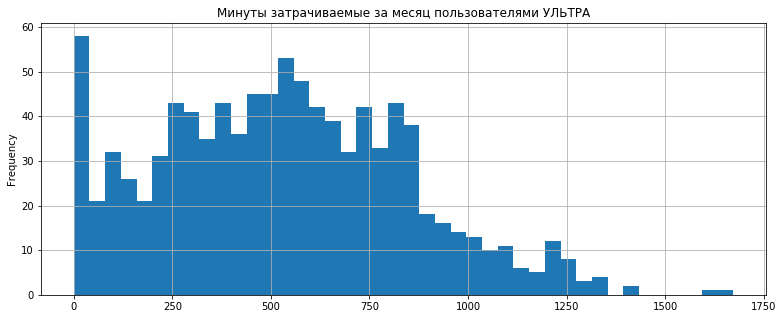

In [76]:
df_omni_ultra['calls_duration'].plot(kind='hist',grid=True,title='Минуты затрачиваемые за месяц пользователями УЛЬТРА',figsize=(13,5),bins=42)

### Кросивое распределение 

In [77]:
df_omni_ultra['message_count'].describe()

count    971.000000
mean      49.792997
std       47.918072
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: message_count, dtype: float64

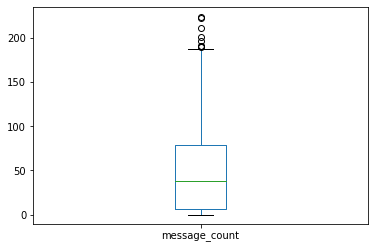

In [78]:
df_omni_ultra['message_count'].plot(kind='box')

In [79]:
# считаем среднее, дисперсию и стандартное отклонение для кол-ва сообщений тарифа УЛЬТРА
ultra_mean1 = df_omni_ultra['message_count'].mean()
ultra_variance1 = df_omni_ultra['message_count'].var()
ultra_std1 = np.sqrt(ultra_variance1)
display(f'Среднее {ultra_mean1},Дисперсия {ultra_variance1},Стандартное отклонение {ultra_std1} для сообщений тарифа УЛЬТРА')

'Среднее 49.79299691040165,Дисперсия 2296.1416416278307,Стандартное отклонение 47.91807218187967 для сообщений тарифа УЛЬТРА'

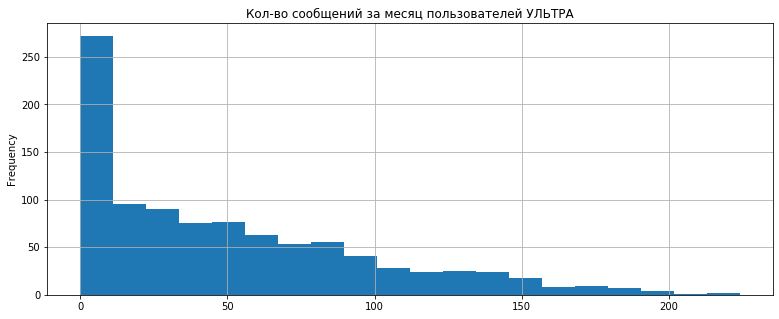

In [80]:
df_omni_ultra['message_count'].plot(kind='hist',grid=True,title='Кол-во сообщений за месяц пользователей УЛЬТРА',figsize=(13,5),bins=20)

### Значительная часть пользователей не отправляет сообщения

In [81]:
df_omni_ultra['gb_used'].describe()

count    971.000000
mean      19.690010
std        9.762103
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: gb_used, dtype: float64

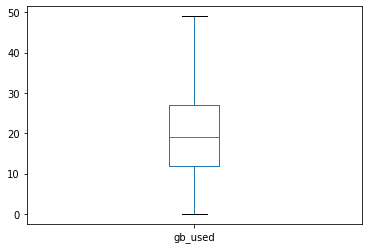

In [82]:
df_omni_ultra['gb_used'].plot(kind='box')

In [83]:
# считаем среднее, дисперсию и стандартное отклонение для использованных GB трафика тарифа УЛЬТРА
ultra_mean2 = df_omni_ultra['gb_used'].mean()
ultra_variance2 = df_omni_ultra['gb_used'].var()
ultra_std2 = np.sqrt(ultra_variance2)
display(f'Среднее {ultra_mean2},Дисперсия {ultra_variance2},Стандартное отклонение {ultra_std2} для использованного интернета тарифа УЛЬТРА')

'Среднее 19.690010298661175,Дисперсия 95.2986526803062,Стандартное отклонение 9.762102882079567 для использованного интернета тарифа УЛЬТРА'

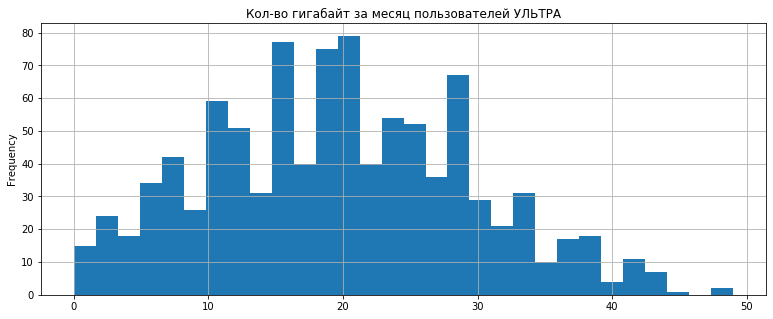

In [84]:
df_omni_ultra['gb_used'].plot(kind='hist',grid=True,title='Кол-во гигабайт за месяц пользователей УЛЬТРА',figsize=(13,5),bins=30)

### Отдаленно напоминает нормальное распределение 

In [85]:
df_omni_smart['calls_duration'].describe()

count    2207.000000
mean      419.880834
std       189.982508
min         0.000000
25%       286.000000
50%       425.000000
75%       546.500000
max      1435.000000
Name: calls_duration, dtype: float64

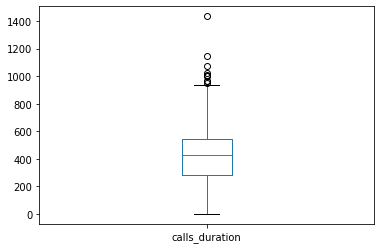

In [86]:
df_omni_smart['calls_duration'].plot(kind='box')

In [87]:
# считаем среднее, дисперсию и стандартное отклонение для звонков тарифа СМАРТ
smart_mean = df_omni_smart['calls_duration'].mean()
smart_variance = df_omni_smart['calls_duration'].var()
smart_std = np.sqrt(smart_variance)
display(f'Среднее= {smart_mean},Дисперсия= {smart_variance},Стандартное отклонение= {smart_std} для тарифа СМАРТ')

'Среднее= 419.8808337109198,Дисперсия= 36093.353426684465,Стандартное отклонение= 189.98250821242587 для тарифа СМАРТ'

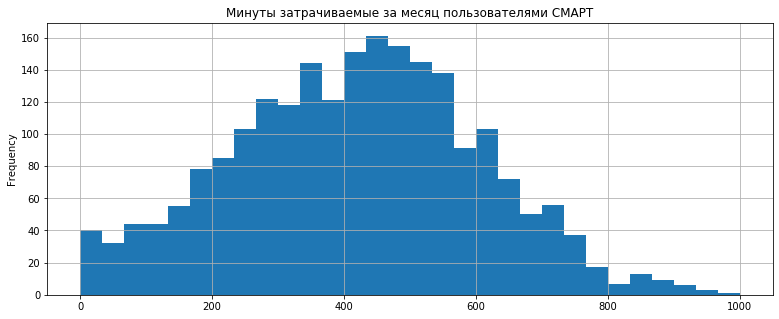

In [88]:
df_omni_smart['calls_duration'].plot(kind='hist',grid=True,title='Минуты затрачиваемые за месяц пользователями СМАРТ',figsize=(13,5),bins=30,range=(0,1000))

### Распределение напоминает нормальное

In [89]:
df_omni_smart['message_count'].describe()

count    2207.000000
mean       33.518804
std        28.298635
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: message_count, dtype: float64

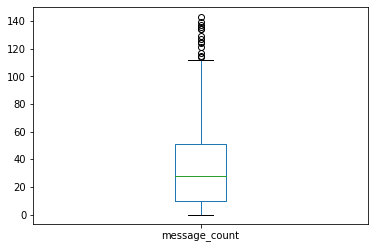

In [90]:
df_omni_smart['message_count'].plot(kind='box')

In [91]:
# считаем среднее, дисперсию и стандартное отклонение для кол-ва сообщений тарифа СМАРТ
smart_mean1 = df_omni_smart['message_count'].mean()
smart_variance1 = df_omni_smart['message_count'].var()
smart_std1 = np.sqrt(smart_variance1)
display(f'Среднее= {smart_mean1},Дисперсия= {smart_variance1},Стандартное отклонение= {smart_std1} для сообщений тарифа СМАРТ')

'Среднее= 33.51880380607159,Дисперсия= 800.812769556689,Стандартное отклонение= 28.298635471638715 для сообщений тарифа СМАРТ'

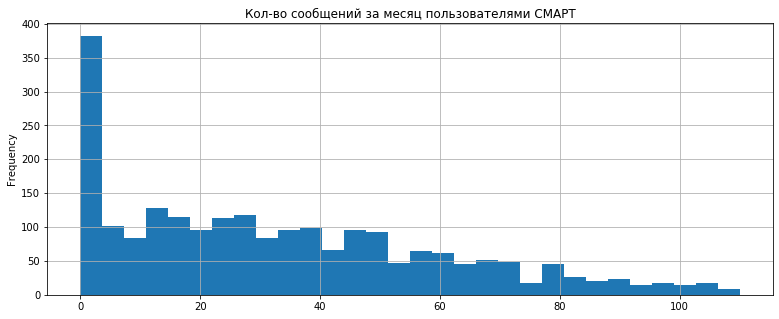

In [92]:
df_omni_smart['message_count'].plot(kind='hist',grid=True,title='Кол-во сообщений за месяц пользователями СМАРТ',figsize=(13,5),bins=30,range=(0,110))

### Значительная часть пользователей не отправляет сообщения

In [93]:
df_omni_smart['gb_used'].describe()

count    2207.000000
mean       16.384232
std         5.730585
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: gb_used, dtype: float64

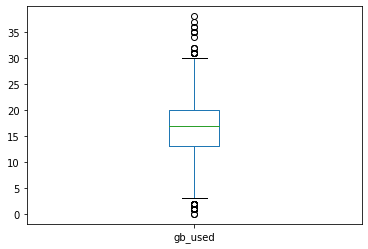

In [94]:
df_omni_smart['gb_used'].plot(kind='box')

In [95]:
# считаем среднее, дисперсию и стандартное отклонение для использованных GB трафика тарифа СМАРТ
smart_mean2 = df_omni_smart['gb_used'].mean()
smart_variance2 = df_omni_smart['gb_used'].var()
smart_std2 = np.sqrt(smart_variance2)
display(f'Среднее= {smart_mean2},Дисперсия= {smart_variance2},Стандартное отклонение= {smart_std2} для затраченных гигабайт тарифа СМАРТ')

'Среднее= 16.38423198912551,Дисперсия= 32.83960619819659,Стандартное отклонение= 5.730585153210498 для затраченных гигабайт тарифа СМАРТ'

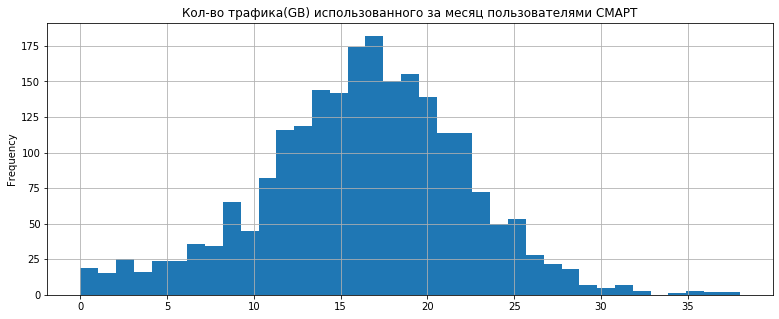

In [96]:
df_omni_smart['gb_used'].plot(kind='hist',grid=True,title='Кол-во трафика(GB) использованного за месяц пользователями СМАРТ',figsize=(13,5),bins=37)

### Похоже на нормальное распределение 

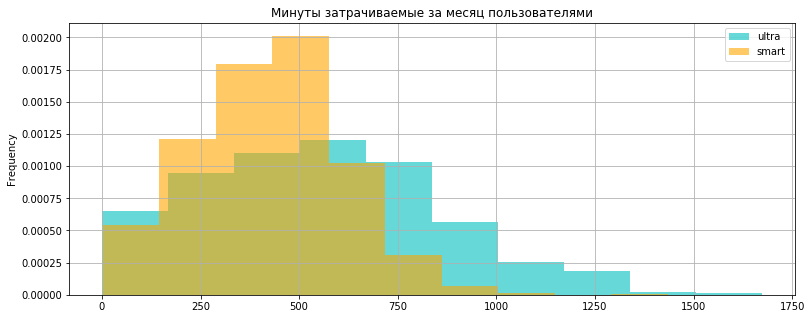

In [97]:
df_omni_ultra.query('calls_duration!=0')['calls_duration'].plot(kind='hist',alpha=0.6,density=True,color='c',label='ultra', grid=True,title='Минуты затрачиваемые за месяц пользователями',figsize=(13,5))
df_omni_smart.query('calls_duration!=0')['calls_duration'].plot(kind='hist',alpha=0.6,density=True,color='orange',label='smart',grid=True,title='Минуты затрачиваемые за месяц пользователями',figsize=(13,5))
plt.pyplot.legend();

### Пользователи тарифа Смарт обычно не превышают лимит в 500 минут за месяц, что не скажешь про ползователей Ультра

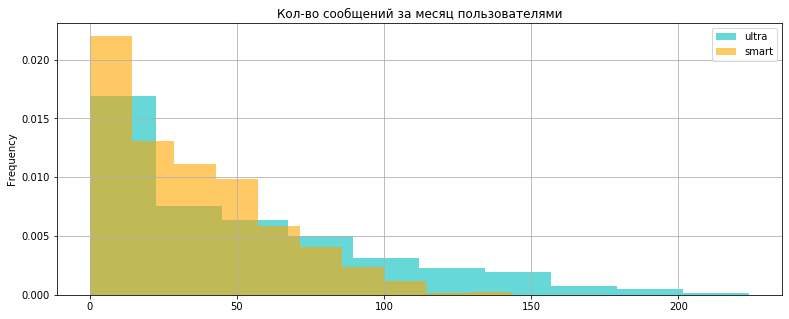

In [98]:
df_omni_ultra['message_count'].plot(kind='hist',alpha=0.6,density=True,color='c',label='ultra',grid=True,title='Кол-во сообщений за месяц пользователей',figsize=(13,5))
df_omni_smart['message_count'].plot(kind='hist',alpha=0.6,density=True,color='orange',label='smart',grid=True,title='Кол-во сообщений за месяц пользователями',figsize=(13,5))
plt.pyplot.legend();

### В отношении использования сообщений поведение пользователей очень похоже 

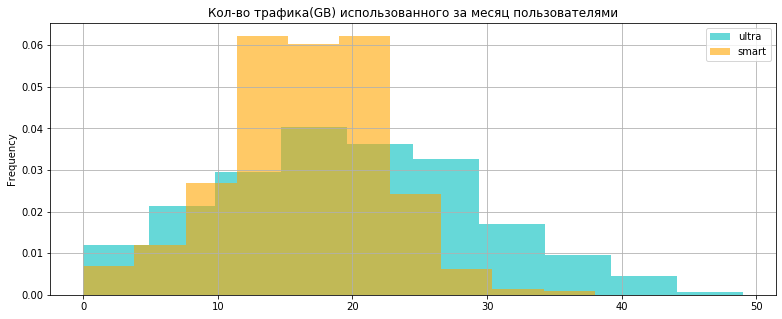

In [99]:
df_omni_ultra['gb_used'].plot(kind='hist',alpha=0.6,density=True,color='c',label='ultra',grid=True,title='Кол-во гигабайт за месяц пользователей',figsize=(13,5))
df_omni_smart['gb_used'].plot(kind='hist',alpha=0.6,density=True,color='orange',label='smart',grid=True,title='Кол-во трафика(GB) использованного за месяц пользователями',figsize=(13,5))
plt.pyplot.legend();

### Пользователи Смарт в основном тратят от 10 до 25 ГБ в месяц, пользователи тарифа Ультра более вариативны

 Были построены гистограммы для распределений затрачиваемых минут , гигиабайт интернета и отправляемых сообщений для пользователей тарифов СМАРТ и УЛЬТРА. Также были построены сравнительные гистограммы. По имеющимся данным были посчитаны средние значения, дисперсия и стандартное отклонение:
    
    * 'Среднее=531.5118434603502,Дисперсия=100403.16970494865,Стандартное отклонение=316.8645920656782 для тарифа затраченных минут УЛЬТРА'
    * 'Среднее 49.79299691040165,Дисперсия 2296.1416416278253,Стандартное отклонение 47.918072181879616 для сообщений тарифа УЛЬТРА'
    * 'Среднее 19.690010298661175,Дисперсия 95.2986526803062,Стандартное отклонение 9.762102882079567 для использованного интернета тарифа УЛЬТРА'
    * 'Среднее= 419.8808337109198,Дисперсия= 36093.35342668448,Стандартное отклонение= 189.98250821242593 для тарифа затраченных минут СМАРТ'
    * 'Среднее= 33.51880380607159,Дисперсия= 800.8127695566855,Стандартное отклонение= 28.298635471638654 для сообщений тарифа СМАРТ'
    * 'Среднее= 16.38423198912551,Дисперсия= 32.83960619819654,Стандартное отклонение= 5.730585153210494 для затраченных гигабайт тарифа СМАРТ'
    
    Сравнение показывает, что по всем параметрам средние значения тарифа УЛЬТРА превышают аналогичные показатели тарифа СМАРТ

# 4. Проверим гипотезы 

In [100]:
# считаем среднее для разных тарифов и проводим p-тест для 2ух выборок
df_omni_smart['income'].mean()

1296.164929768917

In [101]:
df_omni_ultra['income'].mean()

2071.8846549948507

In [102]:
results = st.ttest_ind(df_omni_ultra['income'], df_omni_smart['income'])

In [103]:
if results.pvalue < 0.05:
    display(f'pvalue={results.pvalue} Гипотеза отвергается')
else:
    display(f'pvalue={results.pvalue} Гипотеза не отвергается')

'pvalue=2.421652003116614e-156 Гипотеза отвергается'

Нулевая гипотеза: выборочное среднее по пользователям тарифа СМАРТ равно выборочному среднему тарифа УЛЬТРА. Альтернативная гипотеза: выборочные средние не равны. В результате T-теста мы получили около нулевое значение p-value, соответственно статистически вероятнее будет отвергнуть нулевую гипотезу и предположить, что средние по двум выборкам различаются.

In [104]:
# применяем функцию подсчета доходности для общей таблицы
df_omni['income'] = df_omni.apply(revenue,axis=1)

In [105]:
# выделяем пользователей из Москвы
moscow = df_omni[df_omni['city'] == 'Москва']

In [106]:
# выделяем осстальных пользователей
not_moscow = df_omni[df_omni['city'] != 'Москва']

In [107]:
# считаем среднее для разных ds,jhjr и проводим p-тест
moscow['income'].mean()

1554.637873754153

In [108]:
not_moscow['income'].mean()

1528.1614906832299

In [109]:
results2 = st.ttest_ind(not_moscow['income'], moscow['income'])

In [110]:
if results2.pvalue < 0.05:
    display(f'pvalue={results2.pvalue} Гипотеза отвергается')
else:
    display(f'pvalue={results2.pvalue} Гипотеза не отвергается')

'pvalue=0.4640426222471975 Гипотеза не отвергается'

In [111]:
results2.pvalue

0.4640426222471975

Нулевая гипотеза: выборочное среднее по пользователям из Москвы равно выборочному среднему по остальным пользователям. Альтернативная гипотеза: выборочные средние не равны. В результате T-теста мы получили около p-value=0.46, соответственно статистически вероятнее будет предположить, что выборочные средние для пользователей из Москвы и других пользователей соизмеримы

# 5.Вывод

### Для исследования были предоставлены данные пользователей от оператора сотовой связи. Ознакомившись с предоставленной информацией, проведя предварительную подготовку, по имеющимся данным были посчитаны для 2-ух разных тарифов СМАРТ и УЛЬТРА:
    *количество сделанных звонков и израсходованных минут разговора по месяцам;
    *количество отправленных сообщений по месяцам;
    *объем израсходованного интернет-трафика по месяцам;
    *помесячная выручка с каждого пользователя;

### По проведеным расчетам было изучено сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаны среднее количество, дисперсия и стандартное отклонение. Постройны гистограммы.

### С помощью T-тестов были проверены гипотезы:
    *средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
    *средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
    
### Средняя выручка пользователей тарифов СМАРТ и УЛЬТРА действительно различаются
### Гипотеза об увеличенной выручке пользователей из Москвы не подтверждается статистически

Пользователи тарифа Ультра приносят почти вдвое больше дохода, чем пользователи тарифа Смарт

Были построены гистограммы для распределений затрачиваемых минут , гигиабайт интернета и отправляемых сообщений для пользователей тарифов СМАРТ и УЛЬТРА. Также были построены сравнительные гистограммы. По имеющимся данным были посчитаны средние значения, дисперсия и стандартное отклонение:
    
    * 'Среднее=531.5118434603502,Дисперсия=100403.16970494865,Стандартное отклонение=316.8645920656782 для тарифа затраченных минут УЛЬТРА'
    * 'Среднее 49.79299691040165,Дисперсия 2296.1416416278253,Стандартное отклонение 47.918072181879616 для сообщений тарифа УЛЬТРА'
    * 'Среднее 19.690010298661175,Дисперсия 95.2986526803062,Стандартное отклонение 9.762102882079567 для использованного интернета тарифа УЛЬТРА'
    * 'Среднее= 419.8808337109198,Дисперсия= 36093.35342668448,Стандартное отклонение= 189.98250821242593 для тарифа затраченных минут СМАРТ'
    * 'Среднее= 33.51880380607159,Дисперсия= 800.8127695566855,Стандартное отклонение= 28.298635471638654 для сообщений тарифа СМАРТ'
    * 'Среднее= 16.38423198912551,Дисперсия= 32.83960619819654,Стандартное отклонение= 5.730585153210494 для затраченных гигабайт тарифа СМАРТ'
    
    Сравнение показывает, что по всем параметрам средние значения тарифа УЛЬТРА превышают аналогичные показатели тарифа СМАРТ